## 04 - EDA: Loan duration distribution 

How is the loan period distributed? Are there any patterns or noticeable trends?

The analysis is performed in the following order:

1. Distribution of loan duration in days across the entire (cleaned) data set
2. Broken down by year
3. Based on the previous findings, an analysis of a 7-day periodic cycle

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
# --- global notebook setup (pandas + tueplots/matplotlib style) ---
setup_pandas()
setup_plotting()
from utils import setup_pandas, setup_plotting

# --- project paths ---
PROCESSED_DATA_PATH = Path('../dat/processed')
CLEANED_FILE = PROCESSED_DATA_PATH / "borrowings_2019_2025_cleaned.csv"

# --- load data ---
df = pd.read_csv(
    CLEANED_FILE,
    sep=";",
    quotechar='"',
    encoding="utf-8"
)

print("Loaded shape:", df.shape)

#### Data Integrity Validation

In [14]:
critical_cols = ['issue_id', 'Leihdauer', 'Medientyp']
missing = df[critical_cols].isnull().sum()
open_loans = df['Rückgabedatum/Uhrzeit'].isnull().sum()
logic_errors = (df['Rückgabedatum/Uhrzeit'] < df['Ausleihdatum/Uhrzeit']).sum()

print(f"MISSING VALUES:\n{missing.to_string()}\n")
print(f"Open Loans: {open_loans}")
print(f"Logic Errors (Return < Issue): {logic_errors}")

MISSING VALUES:
issue_id          0
Leihdauer         0
Medientyp    416810

Open Loans: 0
Logic Errors (Return < Issue): 0


#### Filtering
Filter out any loan > 1 year or invalid durations (0/negative)

In [15]:

is_inst = df['Benutzerkategorie'].isin(['INS', 'MZUL'])
is_long = df['Leihdauer'] > 365
is_zero_neg = df['Leihdauer'] <= 0

# Exclusion logic
df_clean = df[~(is_long | is_zero_neg)].copy()

print(f"REMOVAL SUMMARY")
print(f"Total Raw Records:  {len(df)}")
print(f"Invalid Durations (zero or negative):  {is_zero_neg.sum()}")
print(f"Long-term (>1yr):   {is_long.sum()}")
print(f"  - Institutions:   {(is_long & is_inst).sum()}")
print(f"  - Public users:   {(is_long & ~is_inst).sum()}")
print("-" * 25)
print(f"FINAL SUBSET:       {len(df_clean)}")



REMOVAL SUMMARY
Total Raw Records:  2357146
Invalid Durations (zero or negative):  29999
Long-term (>1yr):   0
  - Institutions:   0
  - Public users:   0
-------------------------
FINAL SUBSET:       2327147


### Exploratory Data Analysis

#### Distribution of Loan Durations

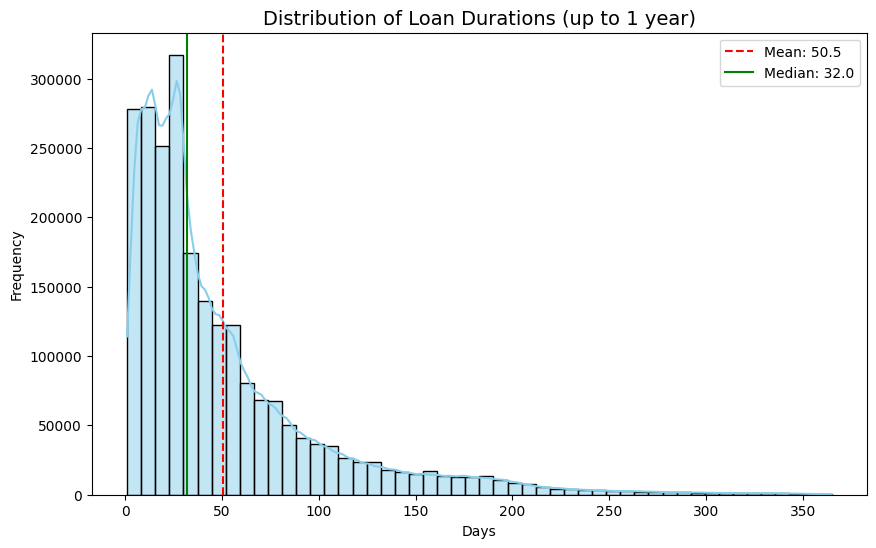

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['Leihdauer'], bins=50, kde=True, color='skyblue')

plt.axvline(df_clean['Leihdauer'].mean(), color='red', linestyle='--', label=f"Mean: {df_clean['Leihdauer'].mean():.1f}")
plt.axvline(df_clean['Leihdauer'].median(), color='green', linestyle='-', label=f"Median: {df_clean['Leihdauer'].median():.1f}")

plt.title('Distribution of Loan Durations (up to 1 year)', fontsize=14)
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.legend()
plt.show()

The visualization of loan durations (filtered for data ≤ 365 days) reveals several key insights:

* **Right-Skewed Distribution:** The data is heavily skewed to the right. While the Median is 32 days, the Mean is 50.5 days. This indicates that a minority of long-term loans significantly pulls the average upward.
* **Policy-Driven Peaks:** We observe distinct frequency peaks, most notably around 28 days. This clearly reflects the standard loan period of 28 days. Another peak can be seen at around 14 days (Loan period for DVDs).
* **Human Behavior:** The steep decline after the 28-day mark shows high compliance with the initial deadline.


#### How does this behave in different years?

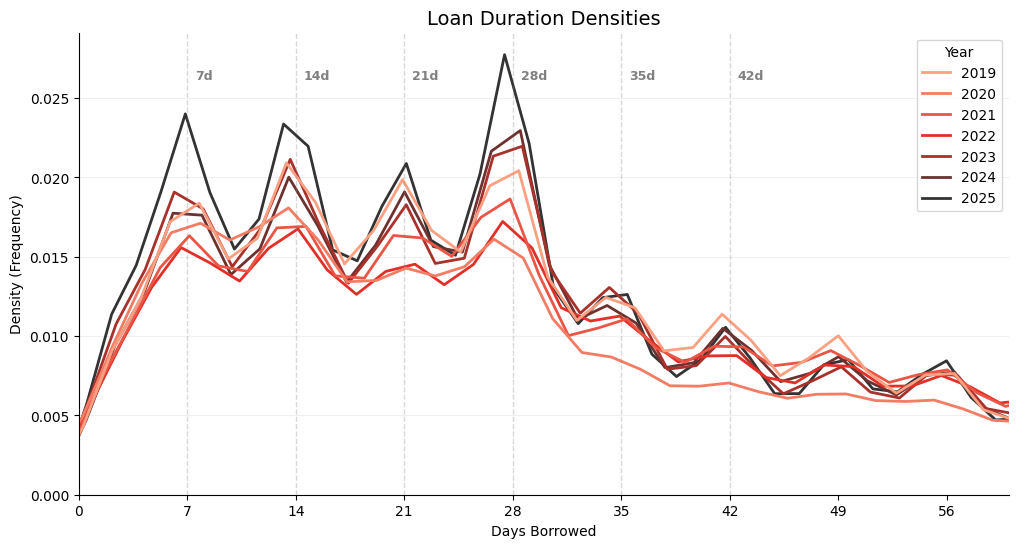

In [17]:
df_clean['Year'] = df_clean['Ausleihdatum/Uhrzeit'].dt.year
plt.figure(figsize=(12, 6))

plot_data = df_clean.sort_values('Year', ascending=False)

sns.kdeplot(
    data=plot_data, 
    x="Leihdauer", 
    hue="Year", 
    palette="Reds_d", 
    common_norm=False,
    bw_adjust=0.4, 
    linewidth=2
)

# Adding vertical helper lines for weeks stamps
peaks_to_mark = [7, 14, 21, 28, 35, 42]
for day in peaks_to_mark:
    plt.axvline(day, color='gray', linestyle='--', alpha=0.3, linewidth=1)
    # Dynamic positioning of text based on current y-limit
    plt.text(day+0.5, plt.gca().get_ylim()[1]*0.9, f'{day}d', 
             color='gray', fontsize=9, fontweight='bold')

plt.title('Loan Duration Densities', fontsize=14)
plt.xlabel('Days Borrowed')
plt.ylabel('Density (Frequency)')
plt.xlim(0, 60)
plt.xticks(range(0, 61, 7))

sns.despine()
plt.grid(axis='y', alpha=0.2)
plt.show()

* 7-Day Periodic Cycles: There is a "Same-Weekday Effect." Strong peaks occur exactly at 7, 14, 21, and 28 days, indicating that users tend to return items more or less on the same day of the week they borrowed them (likely driven by weekly routines or weekend library visits). This holds for all years (2019-2025)

* Policy-Driven Compliance: The highest frequency peak is at 28 days, followed by a abrupt decline. This demonstrates that users maximize the standard 4-week loan period but show high compliance with the official return deadline to avoid late fees.
 
* Extension Echoes: Secondary peaks at 35, 42 and 49 days align with renewal cycles, confirming that extensions follow the same weekly rhythm as initial loans.

* Statistical Skewness: While the Median (32 days) reflects the influence of the 28-day policy, the Mean (50.5 days) is pulled upward by a "Long Tail" of extended loans, characterizing the dataset as significantly right-skewed.

Note: The 2025 density curve shows higher peaks within the first 28 days compared to previous years. This is likely due to the incompleteness of the year, extrem long-term loans (>300 days) have not yet been recorded as returned, artificially concentrating the current distribution within the short-term range.

#### Is there a weekly routine in checkouts and returns?
This heatmap shows the absolute number of transactions for each combination of checkout weekday and return weekday.

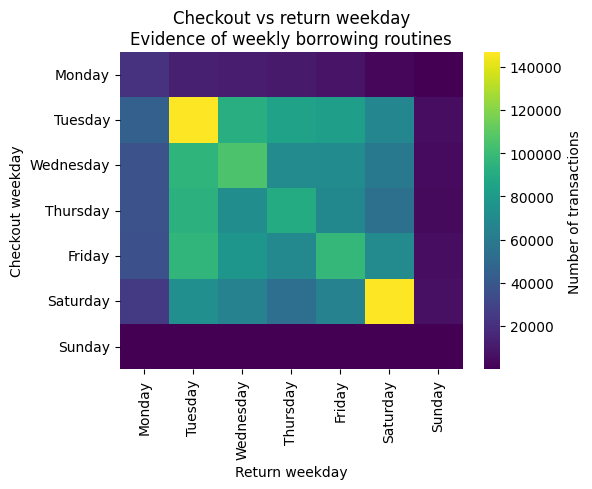

In [18]:
df_clean["checkout_wd"] = df_clean["Ausleihdatum/Uhrzeit"].dt.day_name()
df_clean["return_wd"] = df_clean["Rückgabedatum/Uhrzeit"].dt.day_name()

weekday_order = [
    "Monday", "Tuesday", "Wednesday",
    "Thursday", "Friday", "Saturday", "Sunday"
]

heatmap_data = (
    df_clean
    .groupby(["checkout_wd", "return_wd"])
    .size()
    .unstack(fill_value=0)
    .reindex(index=weekday_order, columns=weekday_order)
)

plt.figure(figsize=(6, 5))

sns.heatmap(
    heatmap_data,
    cmap="viridis",
    cbar_kws={"label": "Number of transactions"}
)

plt.xlabel("Return weekday")
plt.ylabel("Checkout weekday")
plt.title("Checkout vs return weekday\nEvidence of weekly borrowing routines")

plt.tight_layout()
plt.show()


The "hotspots" (yellow) clearly identify Tuesday and Saturday as the peak days for library activity.

Since the library is closed on Sundays and mostly closed on Mondays, these areas appear dark.

The expected high intensity on the diagonal, which would have supported the hypothesis of a 7-day rhythm, is not clearly visible. Only on Tuesdays and Saturdays is it clearly visible that people tend to borrow and return books on the same day of the week. On the other days, it can only be guessed at.

#### How does the distribution look when normalized?
To understand individual behavior regardless of total volume, we normalize the data by row. This represents the conditional probability of a return day given a specific checkout day.

$$P(\text{Return} = r \mid \text{Checkout} = c) = \frac{\text{Transactions on days } (c, r)}{\sum_{i \in \text{Weekdays}} \text{Transactions on days } (c, i)}$$

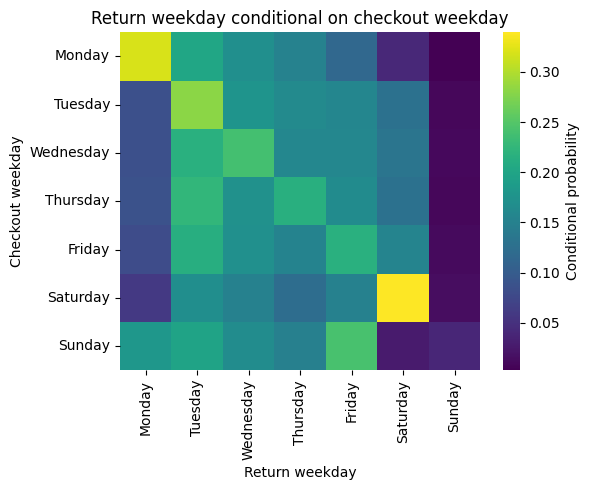

In [19]:
heatmap_norm = heatmap_data.div(heatmap_data.sum(axis=1), axis=0)

plt.figure(figsize=(6, 5))

sns.heatmap(
    heatmap_norm,
    cmap="viridis",
    cbar_kws={"label": "Conditional probability"}
)

plt.xlabel("Return weekday")
plt.ylabel("Checkout weekday")
plt.title("Return weekday conditional on checkout weekday")

plt.tight_layout()
plt.show()


The normalized heatmap makes a diagonal pattern clearer. It shows that, regardless of the absolute number of checkouts on each day, items tend to be returned on specific days relative to when they were borrowed. This highlights consistent weekly return patterns. 

Unlike the first plot, Monday now shows high values because the few people who do borrow on Mondays are highly consistent in returning their items on the same weekdays. This is due to the fact that although the (main) library is closed on Mondays, employees can borrow items themselves on Mondays. 

It is important to keep in mind that the data has been normalized and that there were still very few books borrowed on Sundays in comparison, even though the heat map shows a distribution.

In [20]:
top_return_days = heatmap_norm.idxmax(axis=1)
top_return_probs = heatmap_norm.max(axis=1) * 100

top_patterns = pd.DataFrame({
    "Top Return Day": top_return_days,
    "Probability (%)": top_return_probs.round(2)
})

print(top_patterns)

            Top Return Day  Probability (%)
checkout_wd                                
Monday              Monday            31.86
Tuesday            Tuesday            28.14
Wednesday        Wednesday            23.84
Thursday           Tuesday            22.45
Friday              Friday            21.69
Saturday          Saturday            33.95
Sunday              Friday            24.18
